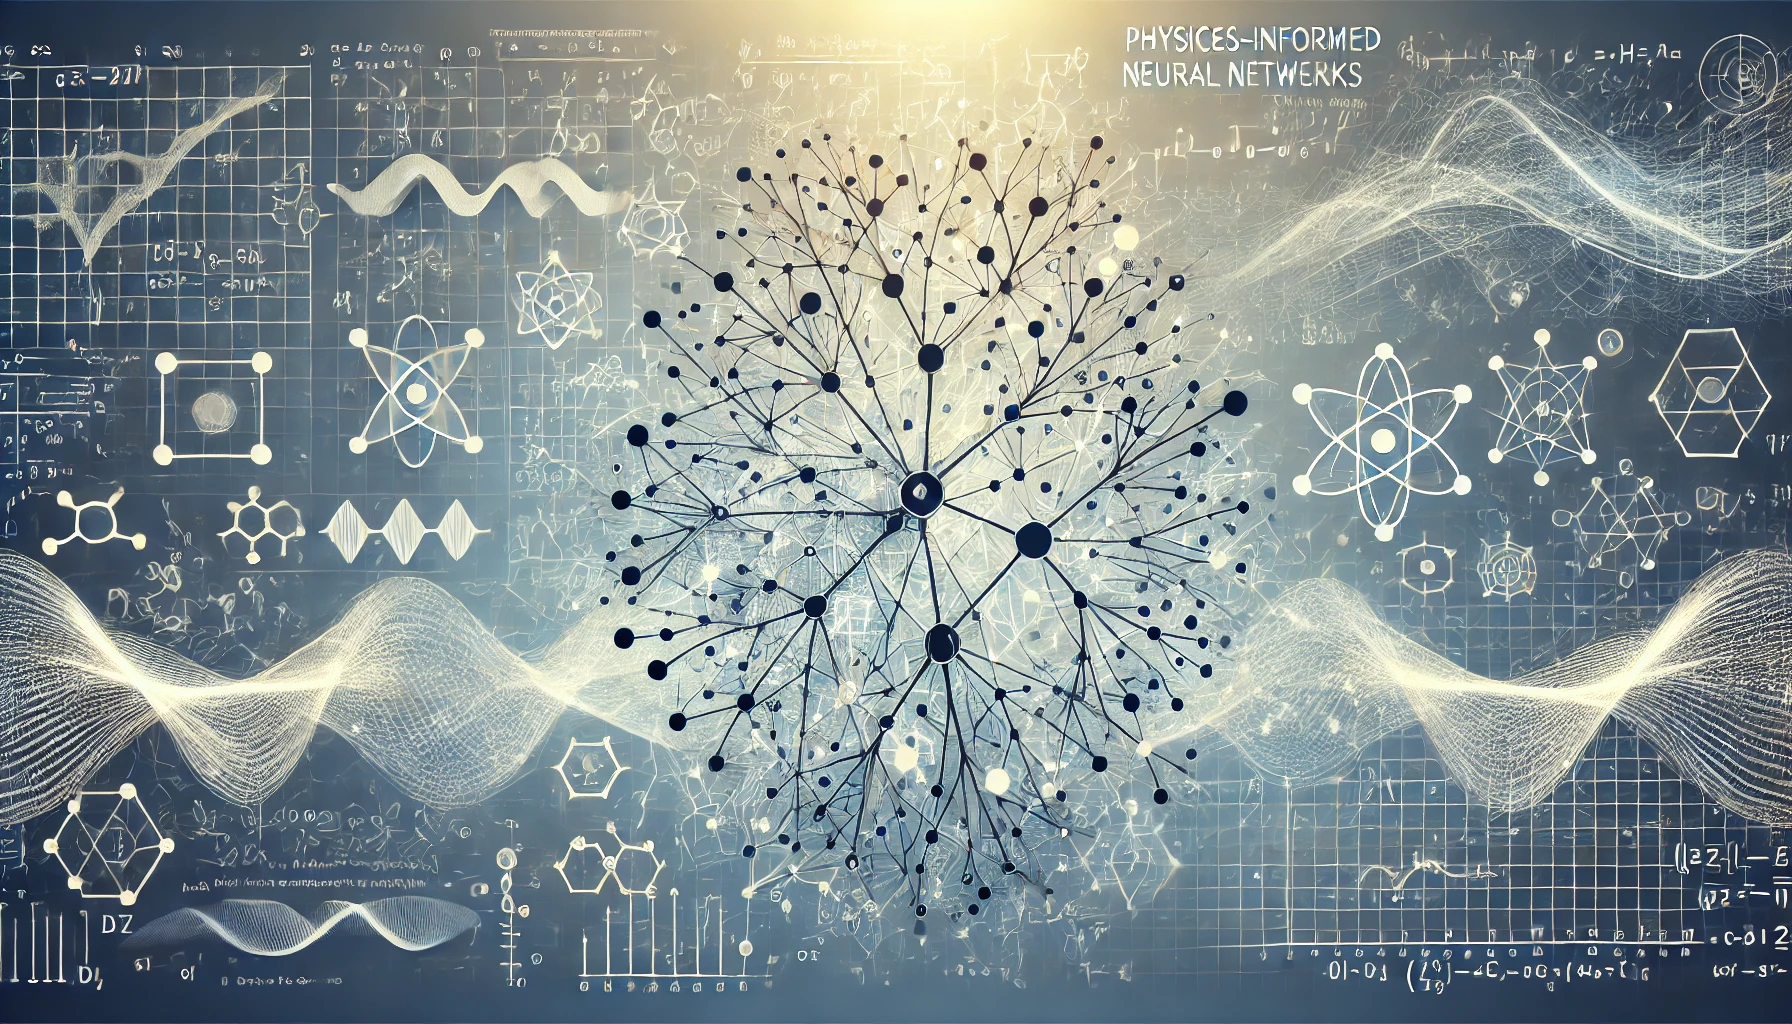

# **<center>A Basic Physics-Informed Neural Networks<center>**
### **<center>Where Machine Learning Meets the Elegance of Physics <center>**

A Physics-Informed Neural Network (PINN) is a type of artificial neural network designed to solve problems involving partial differential equations (PDEs) and other physical constraints by incorporating the underlying physical laws directly into the learning process. This approach leverages the power of neural networks to approximate solutions while embedding physical knowledge, which leads to more accurate and robust predictions, especially for complex systems.

Here's a breakdown of how PINNs work and their key components:

1. **Incorporation of Physical Laws:**
   - **Governing Equations:** PINNs use differential equations that describe the physical phenomena as part of the network’s training. This means that the loss function used during training not only includes the error in predicting data but also includes terms that represent how well the neural network satisfies the physical laws (e.g., conservation laws, Maxwell's equations, Navier-Stokes equations).
   - **Boundary and Initial Conditions:** These are included to ensure that the solution adheres to physical constraints at the boundaries and initial time points.

2. **Architecture:**
   - **Input Layer:** This usually takes in spatial and temporal coordinates (e.g., \(x, y, z, t\)) or other relevant variables.
   - **Hidden Layers:** A series of fully connected neural network layers that process the input data and learn representations.
   - **Output Layer:** Produces predictions for quantities of interest, such as temperature, pressure, velocity fields, etc.

3. **Loss Function:**
   - The loss function for PINNs typically has multiple components:
     - **Data Loss:** Measures the difference between predicted values and known data points (supervised learning).
     - **Physics Loss:** Measures how well the predicted solution satisfies the governing PDEs and boundary conditions (residual loss).
     - **Regularization Terms:** May be added to prevent overfitting and ensure smoothness.

4. **Training Process:**
   - The neural network is trained using backpropagation and gradient-based optimization techniques. The combined loss (data + physics) is minimized during training to improve both the adherence to physical laws and accuracy on known data.

5. **Advantages of PINNs:**
   - **Data Efficiency:**
    - PINNs can be data-efficient, making them suitable for problems where collecting large amounts of labeled data is challenging.

  - **Physics-Consistent Solutions:**
    - PINNs provide solutions that respect the underlying physics, making them applicable to problems governed by known physical laws.

  - **Computational Cost:**
    - Training PINNs may be computationally expensive, particularly when solving high-dimensional or complex problems, as the model needs to learn both the data-driven features and the physical constraints simultaneously.

6. **Applications:**
   - **Fluid Dynamics:** Simulating flow fields and solving Navier-Stokes equations.
   - **Electromagnetics:** Solving Maxwell's equations for electromagnetic field problems.
   - **Quantum Mechanics:** Solving Schrödinger equations for quantum systems.
   - **Structural Analysis:** Predicting stress and strain distributions in materials.
   - **Weather Prediction:** Modeling atmospheric dynamics and climate changes.

7. **Implementation Steps:**
   - **Define the Physical Problem:** Identify the PDEs and boundary conditions that need to be satisfied.
   - **Set Up the Neural Network:** Define the architecture (number of layers, neurons per layer) and initialize weights.
   - **Design the Loss Function:** Include terms for data loss, physics loss, and any regularization.
   - **Training:** Use optimization algorithms (like Adam) to minimize the loss function.
   - **Validation:** Compare results with analytical solutions, if available, or with experimental/observational data.

By integrating physics-based constraints into the neural network, PINNs offer a powerful approach to solving complex scientific and engineering problems where traditional numerical methods may struggle or require extensive computational resources.

# Objectives

1. **Loss Function:**
   - The loss function in a PINN consists of two main components:
     - **Data Fitting Term:** This part ensures that the model fits the available data. It measures the difference between the predicted values and the observed data.
     - **Physics-Informed Term:** This term enforces the PDE constraints. It involves taking derivatives of the neural network predictions with respect to the input variables and comparing them to the corresponding terms in the PDE.
     
     - `Total Loss = Data Fitting Loss + Physics-Informed Loss`

2. **Handling PDE Constraints:**
   - PINNs utilize automatic differentiation to handle the PDE constraints. The gradients of the neural network outputs with respect to the input variables are computed during the training process.
   - For example, in a heat equation $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$, the terms $\frac{\partial u}{\partial t}$ and $\frac{\partial^2 u}{\partial x^2}$ are computed using automatic differentiation and compared to enforce the PDE.

# Importing Necessary Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Training Data

## Generate training data

In [3]:
np.random.seed(0)
num_samples = 1000

x_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
t_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))

u_exact = np.sin(np.pi * x_train) * np.exp(-np.pi**2 * t_train)

## Convert to TensorFlow Tensors

In [4]:
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)

u_exact_tf = tf.convert_to_tensor(u_exact, dtype=tf.float32)

## Combine x and t for Training Input

In [5]:
input_train = tf.concat([x_train_tf, t_train_tf], axis=1)

# Test Data

## Generate Test Data for Prediction

In [6]:
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
t_test = np.linspace(0, 1, 100).reshape(-1, 1)

## Convert to TensorFlow Tensors

In [7]:
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float32)

input_test = tf.concat([x_test_tf, t_test_tf], axis=1)

u_exact_test = np.sin(np.pi * x_test) * np.exp(-np.pi**2 * t_test)
u_exact_test_tf = tf.convert_to_tensor(u_exact_test, dtype=tf.float32)

# Problem (Heat Equation)

Here we will try to solve the Heat Equation through the implementation of PINNs.

In this code, we'll use the heat equation as the governing PDE. The heat equation is given by:
$$ \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2} $$
where $ u $  is the temperature distribution, $ t $ is time, $ x $ is space, and $ \alpha $ is the thermal diffusivity.

## Define the Physics-Informed Neural Network (PINN) Model

In [8]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='tanh', input_dim=2)
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs[:, 0:1]
        t = inputs[:, 1:2]
        concat_input = tf.concat([x, t], axis=1)
        hidden1 = self.dense1(concat_input)
        hidden2 = self.dense2(hidden1)
        output = self.output_layer(hidden2)
        return output

In this part, a class `PINN` is defined as a subclass of `tf.keras.Model`. The model consists of three dense (fully connected) layers. The `call` method defines the forward pass of the model, where the input coordinates (`x` and `t`) are processed through the layers.

## Define the Loss Function (Physics-Informed Loss)

In [9]:
def physics_loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u_pred = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u_pred, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u_pred, t)
        del tape

    alpha = 0.01  # Thermal diffusivity

    # Define the heat equation PDE
    pde_loss = u_t - alpha * u_xx

    return tf.reduce_mean(tf.square(pde_loss))

Here, the `physics_loss` function computes the physics-informed loss. It uses TensorFlow's automatic differentiation to calculate gradients with respect to spatial coordinate `x` (`u_x`) and temporal coordinate `t` (`u_t`). The loss involves the residual of the heat equation.

# Running the PINN Model

## Create and Compile the PINN Model

In [10]:
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The spatial and temporal coordinates are combined into `input_train`. An instance of the `PINN` model is created, and the Adam optimizer is set up for training.

## Model Training Loop

In [16]:
total_loss_history = []
physics_loss_history = []
data_loss_history = []

In [17]:
num_epochs = 500

for epoch in range(num_epochs):
  with tf.GradientTape() as tape:
    physics_loss_value = physics_loss(model, x_train_tf, t_train_tf)
    data_loss_value = tf.reduce_mean(tf.square(model(input_train) - u_exact_tf))
    total_loss = physics_loss_value + data_loss_value

  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  total_loss_history.append(total_loss.numpy())
  physics_loss_history.append(physics_loss_value.numpy())
  data_loss_history.append(data_loss_value.numpy())

  if epoch % 100 == 0:
    print(f"Epoch {epoch}/{num_epochs}, \
            Total Loss: {total_loss.numpy()}, \
            Physics Loss: {physics_loss_value.numpy()}, \
            Data Loss: {data_loss_value.numpy()}")

Epoch 0/500,             Total Loss: 0.021235620602965355,             Physics Loss: 0.0007324633188545704,             Data Loss: 0.020503157749772072
Epoch 100/500,             Total Loss: 0.02094416320323944,             Physics Loss: 0.0007534842588938773,             Data Loss: 0.020190678536891937
Epoch 200/500,             Total Loss: 0.020626995712518692,             Physics Loss: 0.0007618696545250714,             Data Loss: 0.01986512541770935
Epoch 300/500,             Total Loss: 0.020393067970871925,             Physics Loss: 0.0007575532072223723,             Data Loss: 0.0196355152875185
Epoch 400/500,             Total Loss: 0.02028210647404194,             Physics Loss: 0.0007465659873560071,             Data Loss: 0.01953553967177868


The training loop iterates over a specified number of epochs. In each epoch, the physics-informed loss and data fitting loss are calculated. Gradients are computed with respect to the model's trainable variables, and the optimizer updates the model parameters.

### Plotting the Loss

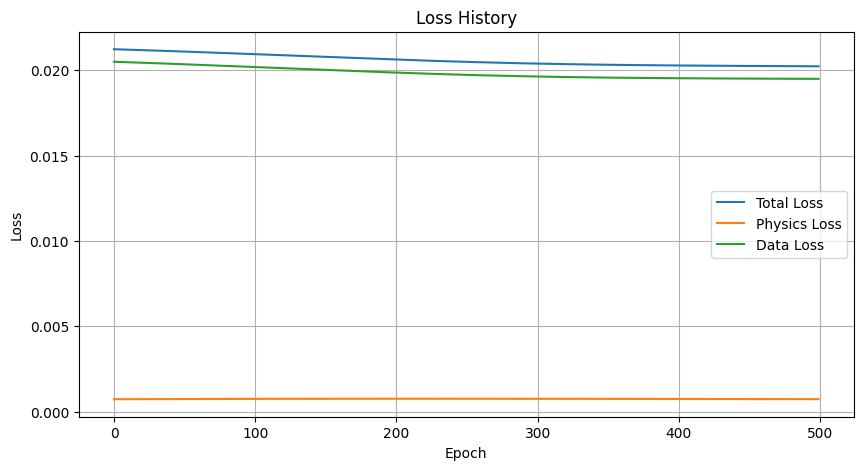

In [20]:
epochs = range(num_epochs)

plt.figure(figsize=(10, 5))
plt.plot(epochs, total_loss_history, label='Total Loss')
plt.plot(epochs, physics_loss_history, label='Physics Loss')
plt.plot(epochs, data_loss_history, label='Data Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid(True)
plt.show()

This is a loss history plot, which is commonly used to track the performance of a machine learning model during training. This specific plot appears to relate to a Physics-Informed Neural Network (PINN), as it includes both data loss and physics loss components. Let's break down the different elements:

***Components of the Plot***

1. **X-axis (Epoch):** This axis represents the number of epochs or training iterations. An epoch is one complete pass through the training dataset. In this plot, the model has been trained for 500 epochs.

2. **Y-axis (Loss):** This axis represents the loss value. Loss is a measure of how well the model's predictions match the expected results. Lower loss values indicate better model performance.

3. **Total Loss (Blue Line):** This line represents the total loss of the neural network, combining both the data loss and the physics loss. The total loss decreases gradually as the number of epochs increases, indicating that the model is learning and improving its predictions over time.

4. **Physics Loss (Orange Line):** This line shows the physics loss, which is associated with how well the model satisfies the physical constraints or differential equations that define the problem. In this plot, the physics loss remains close to zero throughout the training, suggesting that the model is consistently adhering to the physical laws embedded in the PINN.

5. **Data Loss (Green Line):** This line represents the data loss, which measures the difference between the model's predictions and the actual data points (supervised learning data). The data loss also decreases over time, indicating that the model is becoming more accurate in predicting data points.

***Interpretation***

- **Convergence:** The gradual decrease in both total and data loss shows that the model is converging, meaning it is learning to minimize errors effectively over time. However, the rate of decrease slows down as training progresses, which is typical in neural network training.

- **Consistent Physics Loss:** The low, consistent value of the physics loss suggests that the model is effectively incorporating and adhering to the physical constraints from the beginning of training. This indicates a well-balanced loss function where the physics component does not dominate the total loss, allowing the model to focus on data fitting while still respecting physical laws.

- **General Observation:** The plot shows a successful training of a PINN, with both total loss and data loss decreasing, and physics loss remaining negligible. This balance is essential for a PINN to perform well, ensuring it provides accurate predictions while adhering to known physical principles.

In summary, this plot indicates that your Physics-Informed Neural Network is effectively learning the underlying data distribution while simultaneously adhering to the physical constraints imposed by the governing equations.

## Prediction

In [12]:
u_pred = model(input_test)

## Mean Squared Error

In [15]:
mse = tf.reduce_mean(tf.square(u_pred - u_exact_test_tf))
print('Mean Squared Error:', mse.numpy())

Mean Squared Error: 0.002712916


### Plot the absolute error between the predicted and exact solutions

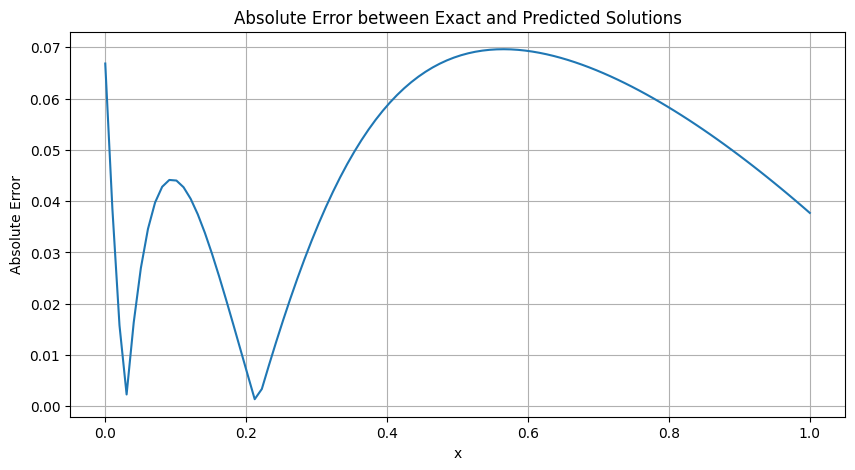

In [24]:
plt.figure(figsize=(10, 5))
error = np.abs(u_exact_test - u_pred.numpy())
plt.plot(x_test, error)
plt.xlabel('x')
plt.ylabel('Absolute Error')
plt.title('Absolute Error between Exact and Predicted Solutions')
plt.grid(True)
plt.show()

The plot you've provided shows the absolute error between the exact (true) solutions and the predicted solutions from a model, which is likely a Physics-Informed Neural Network (PINN) given the context. Here's a detailed explanation of the plot:

***Components of the Plot***

1. **X-axis (x):** This axis represents the spatial or temporal variable, \(x\), over which the model's predictions are being evaluated. In this case, \(x\) ranges from 0 to 1, indicating the domain where the solution is defined.

2. **Y-axis (Absolute Error):** This axis represents the absolute error between the exact solutions (true values) and the predicted solutions (values predicted by the PINN). The absolute error is a measure of the magnitude of the difference between the predicted and actual values, without considering the direction of the error (i.e., it ignores whether the prediction is too high or too low).

3. **Line Plot:** The blue line shows how the absolute error varies across the domain of \(x\). It indicates how accurately the model's predictions match the exact solutions at different points in the domain.

***Interpretation***

- **Error Pattern:** The plot shows that the absolute error is not constant across the domain. The error starts relatively high at \(x = 0\), decreases to a low value near \(x = 0.2\), then increases again, peaking around \(x = 0.6\) before decreasing toward the end of the domain.

- **Regions of Low and High Error:**
  - **Low Error Regions:** Around \(x = 0.2\) and near \(x = 1.0\), the absolute error is quite low, indicating that the model's predictions are closely aligned with the exact solutions in these areas. This suggests that the PINN is performing well in these regions.
  - **High Error Regions:** The error peaks near \(x = 0.6\) at approximately 0.07. This higher error indicates that the model's predictions are less accurate in this region, which might be due to the model's difficulty in capturing certain features of the solution or complexity in the underlying physics.

***Possible Causes of Error***

- **Boundary Conditions:** Higher errors near boundaries or peaks could suggest issues with boundary conditions or how the model handles edges of the domain.
- **Complex Features:** The model might struggle with regions where the solution exhibits more complex behavior, leading to increased error. In physical systems, this could correspond to areas with rapid changes or high gradients.
- **Model Capacity:** If the neural network doesn't have enough capacity (i.e., not enough layers or neurons), it might struggle to accurately represent the solution over the entire domain.

***Conclusion***

This plot highlights the performance of the Physics-Informed Neural Network across the domain of interest. The varying absolute error indicates that while the model performs well in some regions, there are areas where the prediction accuracy could be improved. Understanding these error patterns can help in refining the model, adjusting its architecture, or improving the training process to achieve better overall accuracy.

### Compare predicted solution to the exact solution

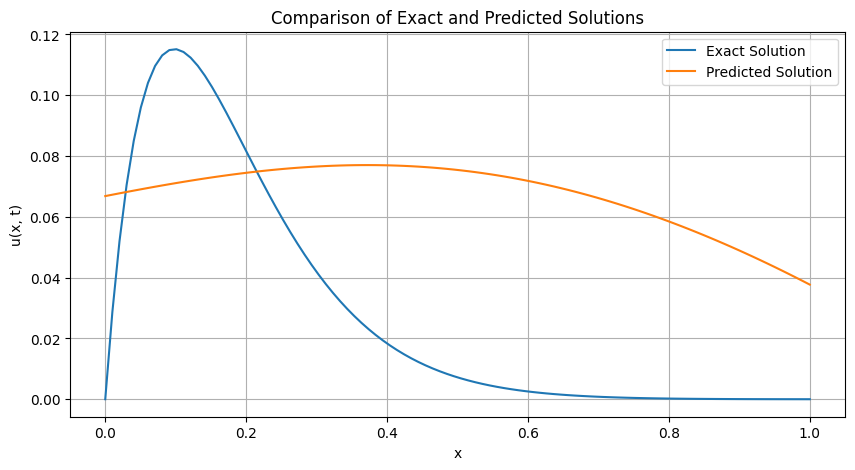

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(x_test, u_exact_test, label='Exact Solution')
plt.plot(x_test, u_pred.numpy(), label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Comparison of Exact and Predicted Solutions')
plt.legend()
plt.grid(True)
plt.show()

This plot compares the exact (true) solution to the predicted solution of a Physics-Informed Neural Network (PINN) model over a given domain. It provides a visual representation of how closely the model's predictions align with the actual solution, which is critical for understanding the performance and accuracy of the model.

***Components of the Plot***

1. **X-axis (x):** This axis represents the spatial or temporal variable, \(x\), over which the solution is defined. The range is from 0 to 1, indicating the domain of interest.

2. **Y-axis (u(x, t)):** This axis represents the solution value of the dependent variable \(u\), which might depend on both space (\(x\)) and potentially time (\(t\)). The exact values of \(u\) are plotted against \(x\).

3. **Blue Line (Exact Solution):** This line represents the true or exact solution of the problem. It is often derived from analytical solutions or high-fidelity numerical simulations. The shape and values of this line are the benchmark against which the model's predictions are compared.

4. **Orange Line (Predicted Solution):** This line represents the solution predicted by the PINN model. The objective is for this line to closely match the blue line, indicating that the model accurately captures the behavior of the underlying physical system.

***Interpretation***

- **Differences between Exact and Predicted Solutions:**
  - The exact solution (blue line) exhibits a peak around \(x \approx 0.2\) and then decreases sharply to near zero as \(x\) approaches 1.
  - The predicted solution (orange line) follows a different pattern, with a less pronounced peak and a more gradual decline, suggesting that the model is not fully capturing the behavior of the exact solution. There is a visible gap between the predicted and exact solutions throughout the domain, particularly noticeable near the peak and towards the right end of the domain.

- **Accuracy of the Model:**
  - The PINN model captures the general trend but misses the exact magnitude and behavior of the true solution. The discrepancy suggests that the model may need further tuning, such as adjusting the architecture (more layers or neurons), improving the training process (e.g., more epochs or a different learning rate), or refining the loss function to put more emphasis on fitting the critical regions (like the peak).

- **Error Analysis Correlation:** This plot complements the absolute error plot shared earlier. The areas where the exact and predicted solutions differ significantly (like around the peak) are also regions where the absolute error is higher, as seen in the previous plot.

***Conclusion***

This plot highlights that while the PINN model is capturing some aspects of the underlying physics, there are discrepancies that need to be addressed for improved accuracy. These discrepancies might be due to various factors, such as model complexity, training data quality, or the specific implementation of the physics-informed loss terms. Further refinement in the model setup and training strategy would be necessary to achieve a closer match between the predicted and exact solutions.

# Conclusion and Result

The low Mean Squared Error (MSE) achieved by the Physics-Informed Neural Network (PINN) underscores its effectiveness in solving the heat equation. PINNs offer advantages, including physics consistency, data efficiency with limited data, versatility for diverse applications, reduced reliance on extensive datasets, automatic differentiation for simplified implementation, improved generalization capabilities, and practical applicability to real-world problems in science and engineering.